In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
from plot_utils import cool_savefig

In [3]:
small_batches = np.zeros((2,1500*500))
medium_batches = np.zeros((2,30*500))
large_batches = np.zeros((2,500))

In [4]:
from glob import glob

filenames = sorted(list(glob('concentration_estimates/*.npz')))
len(filenames)

500

In [5]:
for sim_num in range(500):
    npzfile = np.load(filenames[sim_num])
    
    small_batches[:,sim_num*1500:(sim_num+1)*1500] = npzfile['small_batches']
    medium_batches[:,sim_num*30:(sim_num+1)*30] = npzfile['medium_batches']
    large_batches[:,sim_num] = npzfile['whole_sim']

In [6]:
small_batches_densities = small_batches[0,:]
small_batches_compositions = small_batches[1,:]

medium_batches_densities = medium_batches[0,:]
medium_batches_compositions = medium_batches[1,:]

large_batches_densities = large_batches[0,:]
large_batches_compositions = large_batches[1,:]

In [7]:
print(np.mean(small_batches_densities < np.inf))
print(np.mean(small_batches_compositions < np.inf))

print(np.mean(medium_batches_densities < np.inf))
print(np.mean(medium_batches_compositions < np.inf))

print(np.mean(large_batches_densities < np.inf))
print(np.mean(large_batches_compositions < np.inf))

0.49416933333333335
0.43666666666666665
0.49906666666666666
0.6328666666666667
0.474
0.968


oof geez am I going to have to plot survival functions for the compositional heterogeneity too...

yeah I actually might need to do so -- you know these graphs make it look like the center is around something lower than $100$ for the smaller sizes, but that's a function of the fact that we're missing half of the estimates in some cases, you know? like there's a large amount of implicit censoring/survivorship bias as a result

perhaps it would make more sense to plot $1/\zeta$, since that is the estimator which will actually have nice properties. like these are basically plots of the distribution $1/\max\{X,0\}$ where $X$ is approximately normally distributed (since $X$ is an average). so of course in many respects they look ridiculous. I suppose again on the other hand though that the funkiness and long right tails here does validate my assertion or the assertion that I want to make that for $\zeta=100$ and greater these things are effectively the same as the HPM (HPoMu) already.

**Update:** Several papers in the literature actually already recommend using $1/\zeta$ instead of $\zeta$, for basically the reasons given above.

In [8]:
def small_part(array, x): return array[array < x]
def finite_part(array): return small_part(array, np.inf)

In [9]:
def x_fmt(x, pos):
    return '$10^{{{}}}$'.format(x).replace('.0','').replace('.5', '')

In [10]:
from statsmodels.distributions.empirical_distribution import ECDF

In [11]:
def crest(index):
    return sns.color_palette("crest")[index]

def magma(index):
    return sns.color_palette("magma")[index]

# Density Heterogeneity

In [12]:
small_ecdf = ECDF(small_batches_densities)
print(small_ecdf(10000000))
small_max_finite_val = np.max(finite_part(small_batches_densities))

medium_ecdf = ECDF(medium_batches_densities)
medium_max_finite_val = np.max(finite_part(medium_batches_densities))

large_ecdf = ECDF(large_batches_densities)
large_max_finite_val = np.max(finite_part(large_batches_densities))

0.4941693333333334


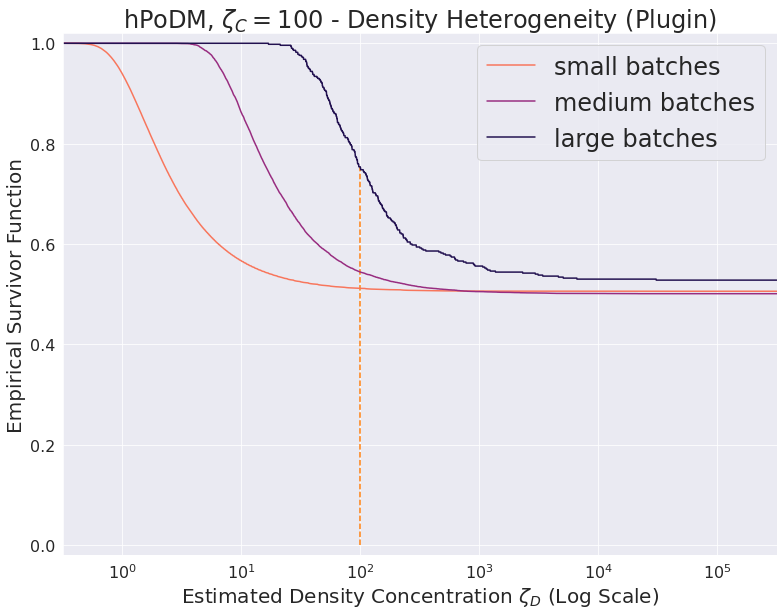

In [13]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8,9.6))
    xvals = np.logspace(start=-0.5, stop=5.5, num=10000)
    axis = sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-small_ecdf(xvals), color=magma(4))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-medium_ecdf(xvals), color=magma(2))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1. - large_ecdf(xvals), color=magma(0))
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.set_ylabel('Empirical Survivor Function', fontsize=20)
    axis.set_ylim((-0.02,1.02))
    plt.stem([2], [1.-large_ecdf(100)], markerfmt='', linefmt='C1--')
    axis.set_xlim((-0.5,5.5))
    axis.set_xlabel('Estimated Density Concentration $\zeta_D$ (Log Scale)', fontsize=20)
    axis.tick_params(labelsize=16)
    title = 'hPoDM, $\zeta_C=100$ - Density Heterogeneity (Plugin)'
    plt.title(title, fontsize=24)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    cool_savefig(title + ' survival')

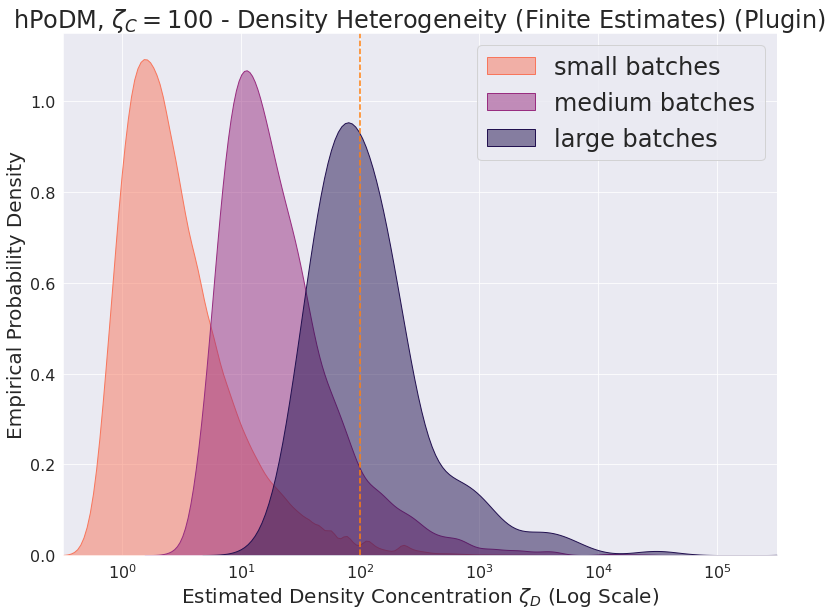

In [14]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8, 9.6))
    axis = sns.kdeplot(np.log(finite_part(small_batches_densities))/np.log(10), color=magma(4), fill=True, alpha=0.5)
    sns.kdeplot(np.log(finite_part(medium_batches_densities))/np.log(10), ax=axis, color=magma(2), fill=True, alpha=0.5)
    sns.kdeplot(np.log(finite_part(large_batches_densities))/np.log(10), ax=axis, color=magma(0), fill=True, alpha=0.5)
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    axis.set_ylabel('Empirical Probability Density', fontsize=20)
    axis.set_xlabel('Estimated Density Concentration $\zeta_D$ (Log Scale)', fontsize=20)
    axis.tick_params(labelsize=16)
    axis.set_xlim((-0.5,5.5))
    axis.set_ylim((0,1.15))
    plt.stem([2], [1.2], markerfmt='', linefmt='C1--')
    title = 'hPoDM, $\zeta_C=100$ - Density Heterogeneity (Finite Estimates) (Plugin)'
    plt.title(title, fontsize=24)
    cool_savefig(title + ' kde')

# Compositional Heterogeneity

In [15]:
small_ecdf_comp = ECDF(small_batches_compositions)
medium_ecdf_comp = ECDF(medium_batches_compositions)
large_ecdf_comp = ECDF(large_batches_compositions)

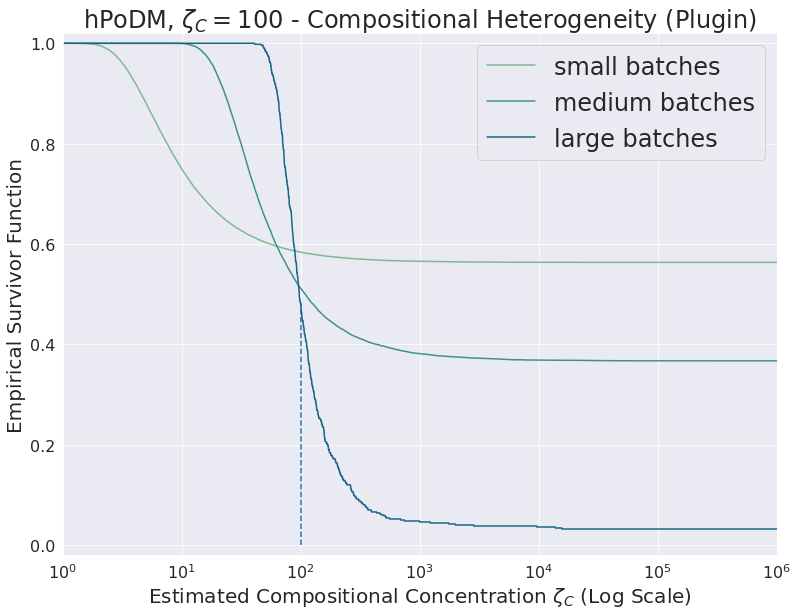

In [16]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8,9.6))
    xvals = np.logspace(start=0, stop=6, num=10000)
    axis = sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-small_ecdf_comp(xvals), color=crest(0))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-medium_ecdf_comp(xvals), color=crest(2))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1. - large_ecdf_comp(xvals), color=crest(4))
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.set_ylabel('Empirical Survivor Function', fontsize=20)
    axis.set_ylim((-0.02,1.02))
    plt.stem([2], [1.-large_ecdf_comp(100)], markerfmt='', linefmt='--')
    axis.set_xlim((0,6))
    axis.set_xlabel('Estimated Compositional Concentration $\zeta_C$ (Log Scale)', fontsize=20)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    axis.tick_params(labelsize=16)
    title = 'hPoDM, $\zeta_C=100$ - Compositional Heterogeneity (Plugin)'
    plt.title(title, fontsize=24)
    cool_savefig(title + ' survival')

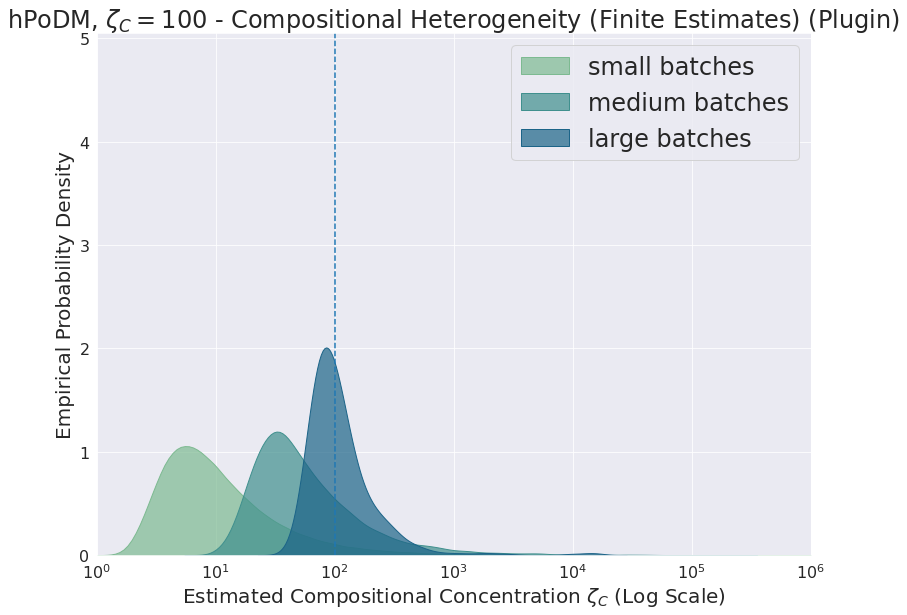

In [17]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8, 9.6))
    axis = sns.kdeplot(np.log(finite_part(small_batches_compositions))/np.log(10), color=crest(0), alpha=0.7, fill=True)
    sns.kdeplot(np.log(finite_part(medium_batches_compositions))/np.log(10), ax=axis, color=crest(2), alpha=0.7, fill=True)
    sns.kdeplot(np.log(finite_part(large_batches_compositions))/np.log(10), ax=axis, color=crest(4), alpha=0.7, fill=True)
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    axis.set_ylabel('Empirical Probability Density', fontsize=20)
    axis.set_xlabel('Estimated Compositional Concentration $\zeta_C$ (Log Scale)', fontsize=20)
    axis.tick_params(labelsize=16)
    axis.set_xlim((0,6))
    axis.set_ylim((0,5.05))
    plt.stem([2], [5.1], markerfmt='', linefmt='--')
    title = 'hPoDM, $\zeta_C=100$ - Compositional Heterogeneity (Finite Estimates) (Plugin)'
    plt.title(title, fontsize=24)
    cool_savefig(title + ' kde')

ok so on one level these are kind of good since they sort of do validate my claims that the $\zeta=100$ looks essentially the same as HPM, but at the same time like graphing is becoming a bit of a nightmare. Although actually these start to look kind of nice on a log scale for the x-axis -- I should probably also try this for the others as well. even e.g. for the survival functions

I mean it is sensible that you are starting to only be able to detect the differences as the sample size is super large, e.g. that there is real overdispersion for $96\%$ when using 15 million size samples, but only $60\%$ when using $500,000$, $40\%$ when using $10,000$, etc.